In [3]:
from datasets import load_dataset

dataset = load_dataset("ade_corpus_v2", "Ade_corpus_v2_classification") 
print(dataset)
print(dataset["train"][0])


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 23516
    })
})
{'text': 'Intravenous azithromycin-induced ototoxicity.', 'label': 1}


In [4]:
from datasets import ClassLabel

label_names = dataset["train"].features["label"].names
print(label_names) 


['Not-Related', 'Related']


In [5]:
import pandas as pd

train_df = pd.DataFrame(dataset["train"])
print(train_df['label'].value_counts(normalize=True))


label
0    0.709942
1    0.290058
Name: proportion, dtype: float64


In [6]:
from datasets import DatasetDict

dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
test_valid = dataset["test"].train_test_split(test_size=0.5, seed=42)

dataset = DatasetDict({
    "train": dataset["train"],
    "validation": test_valid["train"],
    "test": test_valid["test"]
})
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 18812
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2352
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2352
    })
})


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
val_texts = dataset["validation"]["text"]
val_labels = dataset["validation"]["label"]

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=200))
])

baseline.fit(train_texts, train_labels)
val_preds = baseline.predict(val_texts)
print(classification_report(val_labels, val_preds, target_names=label_names))


              precision    recall  f1-score   support

 Not-Related       0.87      0.95      0.91      1649
     Related       0.85      0.66      0.75       703

    accuracy                           0.87      2352
   macro avg       0.86      0.81      0.83      2352
weighted avg       0.86      0.87      0.86      2352



In [8]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"   
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized = dataset.map(tokenize_batch, batched=True)
tokenized = tokenized.remove_columns(["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")


In [12]:
!pip install torch accelerate transformers --upgrade



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = 2

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir="./bert_adr",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=20
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    compute_metrics=compute_metrics,
)

trainer.train()


c:\Users\Akshay10\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.078000,0.190545,0.952806,0.900000,0.947368,0.923077
2,0.205700,0.161749,0.958759,0.929178,0.933144,0.931157
3,0.028700,0.200782,0.960884,0.927273,0.943101,0.935120


c:\Users\Akshay10\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Akshay10\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=7056, training_loss=0.15911230016798056, metrics={'train_runtime': 33021.8241, 'train_samples_per_second': 1.709, 'train_steps_per_second': 0.214, 'total_flos': 3712233880074240.0, 'train_loss': 0.15911230016798056, 'epoch': 3.0})

In [11]:
test_results = trainer.evaluate(tokenized["test"])
print(test_results)


c:\Users\Akshay10\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.21616093814373016, 'eval_accuracy': 0.9506802721088435, 'eval_precision': 0.9053435114503817, 'eval_recall': 0.9165378670788253, 'eval_f1': 0.9109062980030722, 'eval_runtime': 841.3452, 'eval_samples_per_second': 2.796, 'eval_steps_per_second': 0.175, 'epoch': 3.0}


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

baseline_model = LogisticRegression(max_iter=200)
baseline_model.fit(X_train, train_labels)

baseline_preds = baseline_model.predict(X_test)

print(classification_report(test_labels, baseline_preds))


              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1705
           1       0.86      0.68      0.76       647

    accuracy                           0.88      2352
   macro avg       0.87      0.82      0.84      2352
weighted avg       0.88      0.88      0.88      2352



In [15]:
trainer.args.learning_rate = 3e-5
tuning_results = trainer.evaluate(tokenized["validation"])
print(tuning_results)


c:\Users\Akshay10\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.16174930334091187, 'eval_accuracy': 0.9587585034013606, 'eval_precision': 0.9291784702549575, 'eval_recall': 0.9331436699857752, 'eval_f1': 0.9311568488289567, 'eval_runtime': 616.8534, 'eval_samples_per_second': 3.813, 'eval_steps_per_second': 0.238, 'epoch': 3.0}


In [16]:
import torch

texts = dataset["test"]["text"]
true = dataset["test"]["label"]

wrong = []

for i, text in enumerate(texts):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = model(**encoding)
    pred = torch.argmax(output.logits).item()
    if pred != true[i]:
        wrong.append((text, true[i], pred))

wrong[:10]


[('Codeine intoxication in the neonate.', 1, 0),
 ('CONCLUSIONS: Clinicians should be aware that removing a serotonin-2a (S-HT2a) antagonist 1mm a treatment regimen including an agent that increases serotonin in the synaptic cleft may worsen clozapine withdrawal or potentially result in serious adverse drug reactions, such as serotonin syndrome.',
  0,
  1),
 ('Two patients with imminent gangrene of the extremities caused by ergot-induced arteriospasm underwent mechanical dilatation of the arteries when conventional measures such as anticoagulation, vasodilation, and sympathetic blockade produced no improvement.',
  1,
  0),
 ('The responsibility of CCNU in the pathogenesis of pulmonary fibrosis seems very likely.',
  1,
  0),
 ('The causal relationship between hepatotoxicity and methylprednisolone treatment was deemed probable in both cases.',
  0,
  1),
 ("Early data identifies atomoxetine's influence on Tourette symptomatology to be not merely equivocal but potentially suppressive i

In [17]:
trainer.save_model("final_healthcare_transformer_model")
tokenizer.save_pretrained("final_healthcare_transformer_model")


('final_healthcare_transformer_model\\tokenizer_config.json',
 'final_healthcare_transformer_model\\special_tokens_map.json',
 'final_healthcare_transformer_model\\vocab.txt',
 'final_healthcare_transformer_model\\added_tokens.json',
 'final_healthcare_transformer_model\\tokenizer.json')

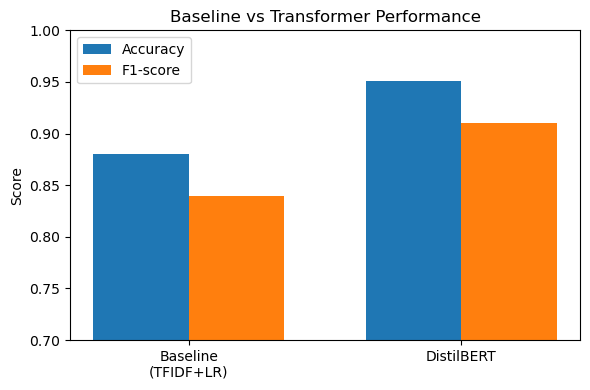

In [18]:
import matplotlib.pyplot as plt
import numpy as np

models = ["Baseline\n(TFIDF+LR)", "DistilBERT"]
accuracy = [0.88, 0.9507]
f1 = [0.84, 0.91]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, accuracy, width, label="Accuracy")
plt.bar(x + width/2, f1, width, label="F1-score")

plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.title("Baseline vs Transformer Performance")
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)
plt.show()
